# Lego World Map

Code inspired from Milan Janosov to create a stylized elevation map of the world.

You can read about his work creating a Lego elevation map of Budapest [here](https://open.substack.com/pub/milanjanosov/p/lego-elevation-map?r=3mp6w8&utm_medium=ios) on his Substack.

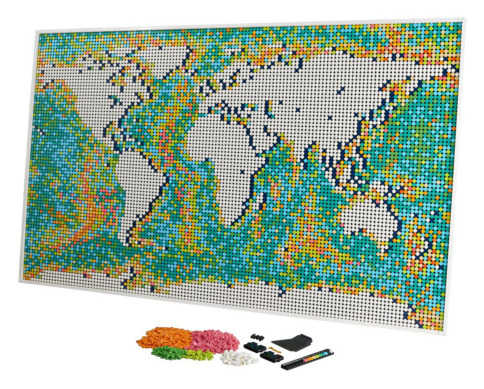

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# https://jaysbrickblog.com/wp-content/uploads/2021/05/\
# LEGO-31203-World-Map-Product-Photo-1024x815.jpg
img = mpimg.imread('figures/LEGO-31203-World-Map-Product-Photo-1024x815.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Lego has previously made a world map, but I think I could do a little better!

## Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.plot import show
from rasterio.merge import merge
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
import sys
import subprocess
import glob
import string
from osgeo import gdal
from pathlib import Path
import os
from shapely.geometry import box, LineString
from PIL import Image, ImageEnhance
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans
from rasterstats import zonal_stats
import math
from scipy import ndimage

DEM Raster data sourced from here:

https://earthexplorer.usgs.gov

## Helper Functions

In [3]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [4]:
seed=rand_gen()
seed

8633

In [5]:
# save random seed for project
with open('seed.txt', 'w') as file:
    file.write(str(seed))

In [6]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x16683FBC0

## Merge DEMs

In [7]:
# adapted from https://gis.stackexchange.com/questions/449569/\
# merging-a-large-number-of-geotiff-files-via-gdal-merge-py

# paths
input_folder=Path('../_data/world_data/dem_tile_world_gtopo30')
output_folder=Path('../_data/world_data')
output_file=output_folder / "dem_world_gtopo30.tiff"
vrt_file=output_folder / "merged.vrt"

# create output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# find and list all .tif files
input_files = [Path(file) for file in glob.glob(str(input_folder / '*.tif'))]
print(f"Found {len(input_files)} files to merge.")

# dictionary for temporary short names
# to manage potentially long filenames
original_names = {}
characters = string.digits + string.ascii_letters

# temporarily rename files to short names
print("Renaming files temporarily...")
for i, file in enumerate(input_files):
    new_name = f"{characters[i % len(characters)]}{characters[i // len(characters)]}.t"
    new_path = file.parent / new_name
    file.rename(new_path)
    original_names[new_path] = file

# build VRT from renamed files
print("Building VRT file...")
gdal.BuildVRT(str(vrt_file), [str(file) for file in original_names.keys()])

# translate VRT to TIFF
print("Translating VRT to TIFF...")
gdal.Translate(str(output_file), str(vrt_file))

# restore original file names
print("Restoring original file names...")
for new_path, original_path in original_names.items():
    new_path.rename(original_path)

# clean up VRT file
print("Cleaning up temporary files...")
vrt_file.unlink()

print(f"Merging completed. Final output located at: {output_file}")

Found 33 files to merge.
Renaming files temporarily...
Building VRT file...
Translating VRT to TIFF...
Restoring original file names...
Cleaning up temporary files...
Merging completed. Final output located at: ../_data/world_data/dem_world_gtopo30.tiff


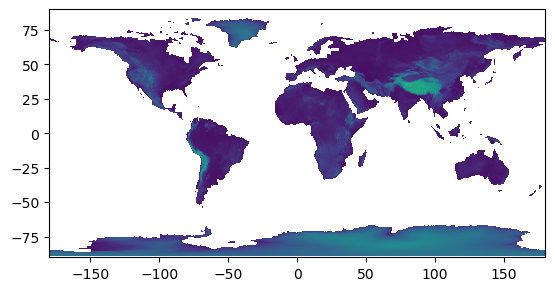

<Axes: >

In [8]:
# view file
fp=r'../_data/world_data/dem_world_gtopo30.tiff'
img=rio.open(fp)
show(img)

Saved image to ../_figs/dem_world.jpg


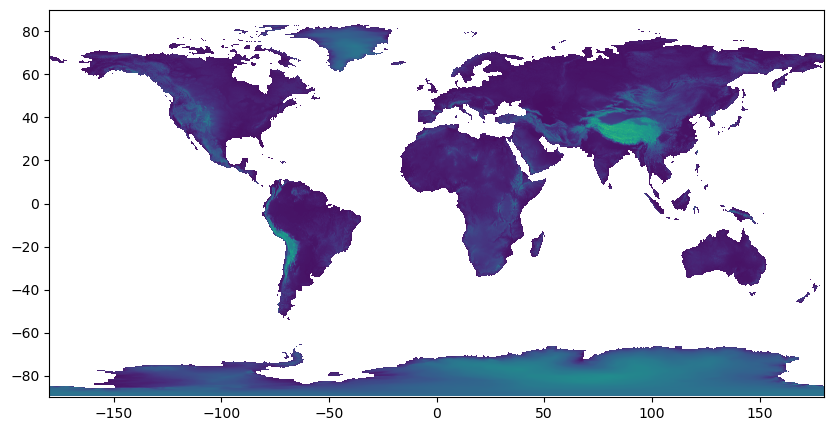

In [9]:
# save as jpg for posterity

# define paths
tiff_file=Path('../_data/world_data/dem_world_gtopo30.tiff')
output_image=Path('../_figs/dem_world.jpg')
output_image.parent.mkdir(parents=True,exist_ok=True)

# open and save as jpg
with rio.open(tiff_file) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src,ax=ax)
    plt.savefig(output_image,format="jpg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    
print(f'Saved image to {output_image}')

## "Lego-fy" or downsample polygon of earth

Now we have to rasterize the elevation map. This is crucial as we'll be eventually making this map in Lego, which are bricks (duh).

We need to have a look at the boundaries of the world. I have a file downloaded already:

In [10]:
import geopandas as gpd
import shapely
print(f'GeoPandas version: {gpd.__version__}')
print(f'Shapely version: {shapely.__version__}')

GeoPandas version: 0.14.2
Shapely version: 2.0.6


<Axes: >

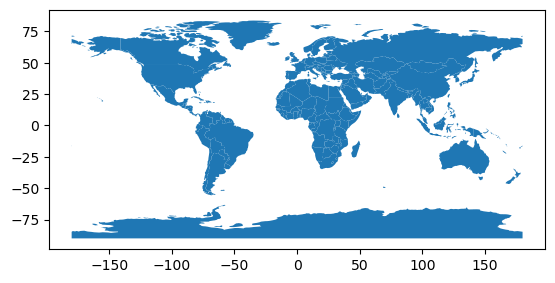

In [11]:
borders = gpd.read_file('../_data/world_data/world_borders.geojson')
borders.plot()

In [12]:
# merge into one mega-world-spanning polygon
world_polygon = borders.geometry.unary_union
world = gpd.GeoDataFrame(geometry=[world_polygon], crs=borders.crs)
world.to_parquet('../_data/world_data/world_polygon.parquet', engine='pyarrow')

/Applications/Anaconda/anaconda3/envs/lego/lib/python3.10/site-packages/shapely/set_operations.py:421: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Figure size 640x480 with 0 Axes>

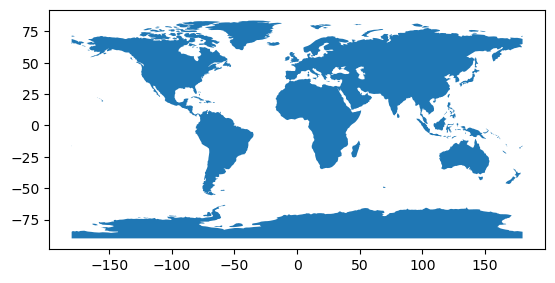

In [13]:
world = gpd.read_parquet('../_data/world_data/world_polygon.parquet')
plt.figure()
world.plot()

plt.savefig('figures/world_polygon.jpg',bbox_inches='tight')

Milan made a function that split the polygon into a grid with a user-specified number of cells. We may have to adapt it as our world map is not a square.

In [14]:
# Create the grid polygons
def create_grid(minx, miny, maxx, maxy, num_cells_x, num_cells_y):
    grid_polygons = []
    cell_width = (maxx - minx) / num_cells_x
    cell_height = (maxy - miny) / num_cells_y

    for i in range(num_cells_x):
        for j in range(num_cells_y):
            x = minx + i * cell_width
            y = miny + j * cell_height
            grid_polygons.append(box(x, y, x + cell_width, y + cell_height))
    
    return grid_polygons

In [15]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# extract the bounding box of the world from the GeoDataFrame
bounds = world.bounds

minx = bounds.minx.values[0]
miny = bounds.miny.values[0]
maxx = bounds.maxx.values[0]
maxy = bounds.maxy.values[0]

We'll have to figure out what the dimensions of the Lego set are (in Lego studs), as that is a good size for our eventual Lego map.
* The map is $5 x 16 \text{ or } 80\text{ studs }$in height
* The map is $8 x 16 \text{ or } 128\text{ studs }$in width

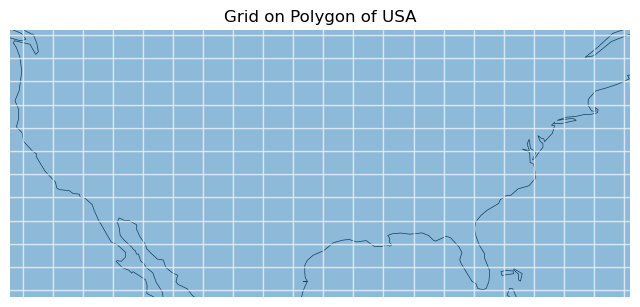

In [18]:
# Create a user-defined grid within the bounding box of the world
height = 80
width = 128
grid_crs = world.crs.to_epsg()
grid_polygons = create_grid(minx, miny, maxx, maxy, width, height)
gdf_grid = gpd.GeoDataFrame(grid_polygons, columns=['geometry'])
gdf_grid.crs = grid_crs

# Visualize the grid overlaid on the map
f, ax = plt.subplots(1, 1, figsize=(8, 8))
world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
gdf_grid.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')

# just view USA for now
ax.set_xlim(-125, -66.9)
ax.set_ylim(24.4, 49.4)

plt.title('Grid on Polygon of USA')

plt.savefig('figures/grid_usa.jpg',bbox_inches='tight')
plt.savefig('figures/grid_usa.pdf',bbox_inches='tight')
plt.savefig('figures/grid_usa.png',bbox_inches='tight')

plt.show()

### What about square grids with diagonal cross-lines?


That would allow us to have 45-degree shapes in addition to the 90-degree shapes of "pixelly" Lego.

We will modify the above code to include X's.

In [19]:
# Function to create the grid polygons and diagonal lines
def create_grid_with_x(minx, miny, maxx, maxy, num_cells_x, num_cells_y):
    grid_polygons = []
    cross_lines = []
    cell_width = (maxx - minx) / num_cells_x
    cell_height = (maxy - miny) / num_cells_y

    for i in range(num_cells_x):
        for j in range(num_cells_y):
            x = minx + i * cell_width
            y = miny + j * cell_height
            # Create the square polygon
            grid_polygons.append(box(x, y, x + cell_width, y + cell_height))
            
            # Create the diagonal cross-lines ("X")
            top_left = (x, y + cell_height)
            bottom_right = (x + cell_width, y)
            top_right = (x + cell_width, y + cell_height)
            bottom_left = (x, y)
            
            # Add the two diagonal lines
            cross_lines.append(LineString([top_left, bottom_right]))
            cross_lines.append(LineString([top_right, bottom_left]))

    return grid_polygons, cross_lines

In [20]:
# extract the bounding box of the world from the GeoDataFrame
bounds = world.bounds
minx = bounds.minx.values[0]
miny = bounds.miny.values[0]
maxx = bounds.maxx.values[0]
maxy = bounds.maxy.values[0]

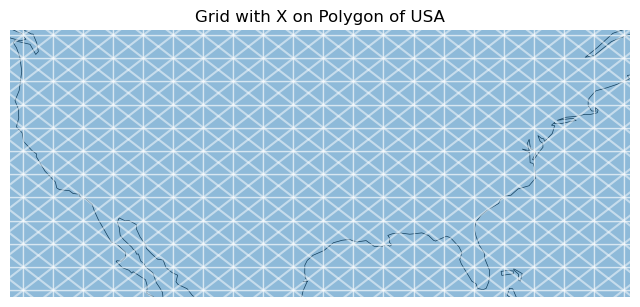

In [21]:
# create a user-defined grid within the bounding box of the world
height = 80
width = 128
grid_x_crs = world.crs.to_epsg()
grid_x_polygons, cross_lines = create_grid_with_x(minx, miny, maxx, maxy, width, height)

# create GeoDataFrames for the grid and diagonal lines
gdf_x_grid = gpd.GeoDataFrame({'geometry': grid_x_polygons})
gdf_x_grid.crs = grid_x_crs

gdf_x_lines = gpd.GeoDataFrame({'geometry': cross_lines})
gdf_x_lines.crs = grid_x_crs

# visualize the grid and cross-lines overlaid on the map
f, ax = plt.subplots(1, 1, figsize=(8, 8))
world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
gdf_x_grid.plot(ax=ax, edgecolor='w', alpha=0.5)
gdf_x_lines.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')

# zoom into the USA
ax.set_xlim(-125, -66.9)
ax.set_ylim(24.4, 49.4)

plt.title('Grid with X on Polygon of USA')

plt.savefig('figures/grid_x_usa.jpg', bbox_inches='tight')
plt.savefig('figures/grid_x_usa.pdf', bbox_inches='tight')
plt.savefig('figures/grid_x_usa.png', bbox_inches='tight')

plt.show()

## Map elevation values into the grid

### With square grid:

In [22]:
file_path='../_data/world_data/dem_world_gtopo30.tiff'

# open GeoTIFF file
with rio.open(file_path) as src:
    print('Number of bands:', src.count)
    print('CRS:', src.crs)
    print('Bounds:', src.bounds)
    print('Metadata:', src.meta)
    print('Description:', src.descriptions)
    
    # check descriptions and statistics of each band
    for band in range(1, src.count + 1):
        print(f"Band {band} description: {src.descriptions[band-1]}")
        data = src.read(band)
        print(f"Band {band} min value: {data.min()}, max value: {data.max()}")

Number of bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-89.99999999992801, right=179.99999999985602, top=90.0)
Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333333333, 0.0, -180.0,
       0.0, -0.00833333333333, 90.0)}
Description: (None,)
Band 1 description: None
Band 1 min value: -9999, max value: 8752


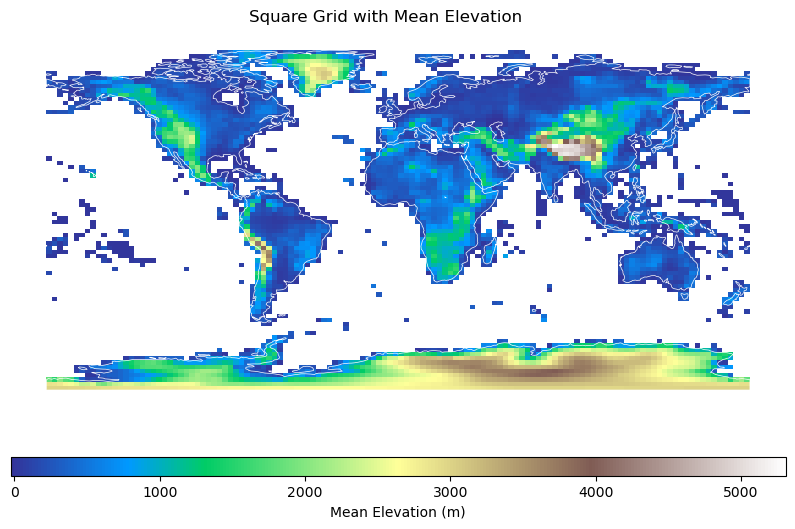

In [23]:
# compute zonal statistics for the grid cells based on elevation data
with rio.open(file_path) as src:
    # use zonal_stats to calculate mean elevation for each grid cell
    stats = zonal_stats(
        gdf_grid,                     # grid polygons
        src.read(1),                  # elevation data (band 1)
        affine=src.transform,         # geoTIFF affine transform
        stats=["mean"],               # compute mean elevation
        nodata=src.nodatavals[0]      # ignore nodata values
    )

# extract the mean elevation for each grid cell
gdf_grid["elevation_mean"] = [stat["mean"] for stat in stats]

# inspect the updated grid with elevation data
# print(gdf_grid.head())

# visualize the grid with elevation values
f, ax = plt.subplots(1, 1, figsize=(10, 10))

# define a color map and normalization for the data
cmap = plt.cm.terrain  # color map
vmin = gdf_grid["elevation_mean"].min()
vmax = gdf_grid["elevation_mean"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# plot the grid with elevation data using the defined color map
gdf_grid.plot(
    ax=ax,
    column="elevation_mean",
    cmap=cmap,
    edgecolor="none"
)

world.plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)

# create a divider for placing the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# add the color bar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for ScalarMappable
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Mean Elevation (m)")

ax.axis("off")
plt.suptitle("Square Grid with Mean Elevation", y=0.74)

plt.savefig('figures/square_grid_with_elevation.pdf', bbox_inches='tight')
plt.savefig('figures/square_grid_with_elevation.jpg', bbox_inches='tight')
plt.savefig('figures/square_grid_with_elevation.png', bbox_inches='tight')

plt.show()

### With square-X grid:

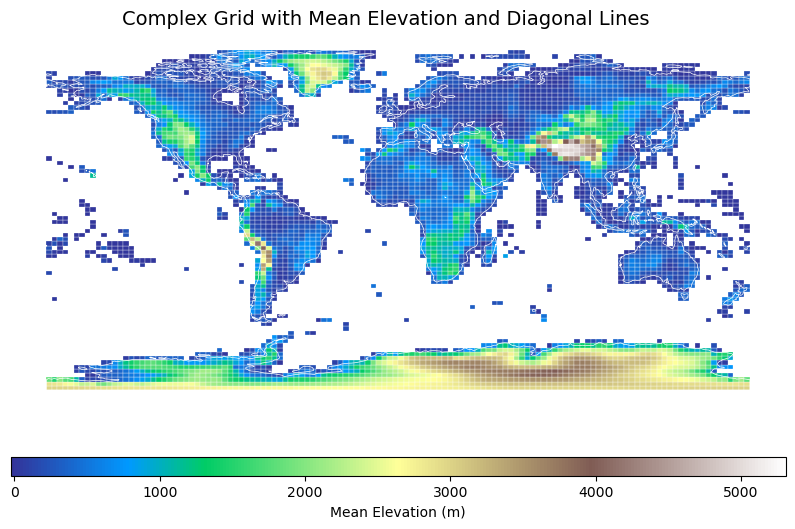

In [24]:
# compute zonal statistics for the grid cells based on elevation data
with rio.open(file_path) as src:
    # use zonal_stats to calculate mean elevation for each grid cell
    stats = zonal_stats(
        gdf_x_grid,                     # grid polygons
        src.read(1),                  # elevation data (band 1)
        affine=src.transform,         # geoTIFF affine transform
        stats=["mean"],               # compute mean elevation
        nodata=src.nodatavals[0]      # ignore nodata values
    )

# extract the mean elevation for each grid cell
gdf_x_grid["elevation_mean"] = [stat["mean"] for stat in stats]

# inspect the updated grid with elevation data
# print(gdf_grid.head())

# visualize the grid with elevation values and diagonal lines
f, ax = plt.subplots(1, 1, figsize=(10, 10))

# define a color map and normalization for the data
cmap = plt.cm.terrain  # color map
vmin = gdf_x_grid["elevation_mean"].min()
vmax = gdf_x_grid["elevation_mean"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# plot the grid with elevation data using the defined color map
gdf_x_grid.plot(
    ax=ax,
    column="elevation_mean",
    cmap=cmap,
    edgecolor="white",  # optional: white edges for clarity
    linewidth=0.2
)

# # plot the diagonal lines on top of the grid
# gdf_x_lines.plot(ax=ax, edgecolor="w", alpha=0.5)

# add world boundaries for context
world.plot(ax=ax, color="none", edgecolor="white", linewidth=0.5)

# create a divider for placing the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# add the color bar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for ScalarMappable
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Mean Elevation (m)")

ax.axis("off")
f.suptitle("Complex Grid with Mean Elevation and Diagonal Lines", y=0.74, fontsize=14)

plt.show()

This did change the figure slightly, though it might not be worth the trouble. It will increase the precision but might also increase the Lego piece count.

We will focus on just the square grid.

## Discretize elevation

As a final step for encoding elevation into Lego, we need to discretize the height into levels, under 10 levels, so that our map can have a 3D effect.

In [25]:
gdf_grid['elevation_mean'].describe()

count    4830.000000
mean      886.269964
std      1043.691208
min       -25.742125
25%       155.599424
50%       409.542953
75%      1207.245623
max      5308.531406
Name: elevation_mean, dtype: float64

In [26]:
# number of levels you want to display
n_levels = 7  # Set this to 5, 6, 7, or any desired number of levels

# step 1: filter out very low elevation values (e.g., below sea level)
threshold = 1  # elevation threshold (set to X meters)
gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

print(f"Original grid size: {len(gdf_grid)}")
print(f"Filtered grid size (land only): {len(gdf_land)}")

# step 2: logarithmic transformation with error handling
gdf_land['log'] = gdf_land['elevation_mean'].apply(lambda x: math.log(x + 1) if not np.isnan(x) else np.nan)

# step 3: scaling values to the desired number of levels
val_min = gdf_land['log'].min()
val_max = gdf_land['log'].max()

# normalize the values to range [0, n_levels-1]
gdf_land['height_level'] = gdf_land['log'].apply(
    lambda v: round((v - val_min) / (val_max - val_min) * (n_levels - 1)) if not np.isnan(v) else np.nan
)

# step 4: print stats (Optional)
print("Height Level Min:", gdf_land['height_level'].min())
print("Height Level Max:", gdf_land['height_level'].max())

Original grid size: 10240
Filtered grid size (land only): 4822
Height Level Min: 0
Height Level Max: 6


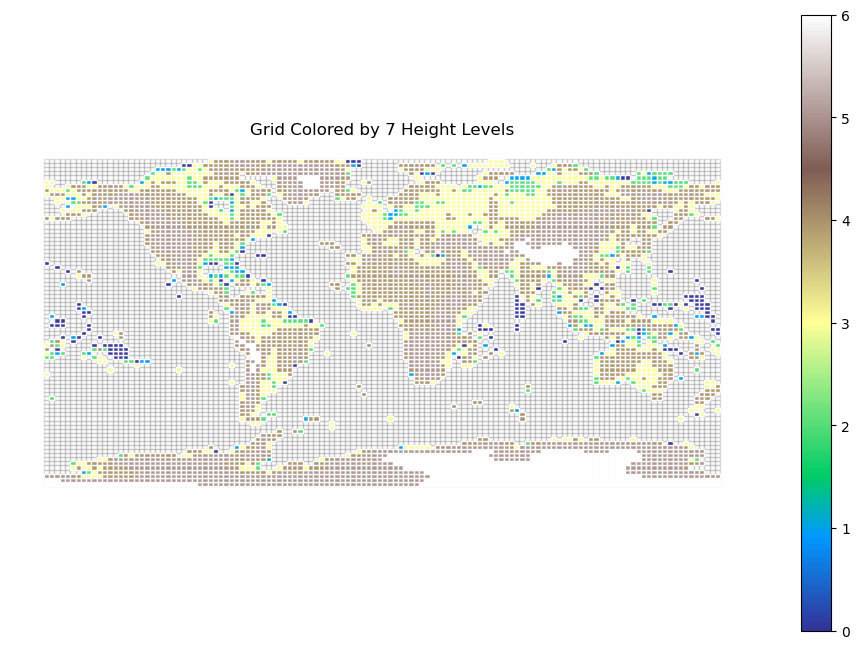

In [27]:
# step 4: visualization
f, ax = plt.subplots(1, 1, figsize=(12, 8))

# base grid with grey edges
gdf_grid.plot(ax=ax, color='w', edgecolor='grey', alpha=0.25)

# plot the grid colored by height levels
gdf_land.plot(
    ax=ax,
    column='height_level',
    edgecolor='w',
    cmap='terrain',  # Choose any colormap
    alpha=0.95,
    legend=True
)

ax.axis('off')
plt.title(f"Grid Colored by {n_levels} Height Levels")
plt.show()

This is not ideal. Most of the land surface appears to be at one elevation, which is not correct. We want a more dynamic map.

The quantile binning method to enable a more balanced representation, so that each level gets an approximately equal share of the grid cells. It is also dynamically driven, so as the data changes, the thresholds will adapt.

### 6 levels

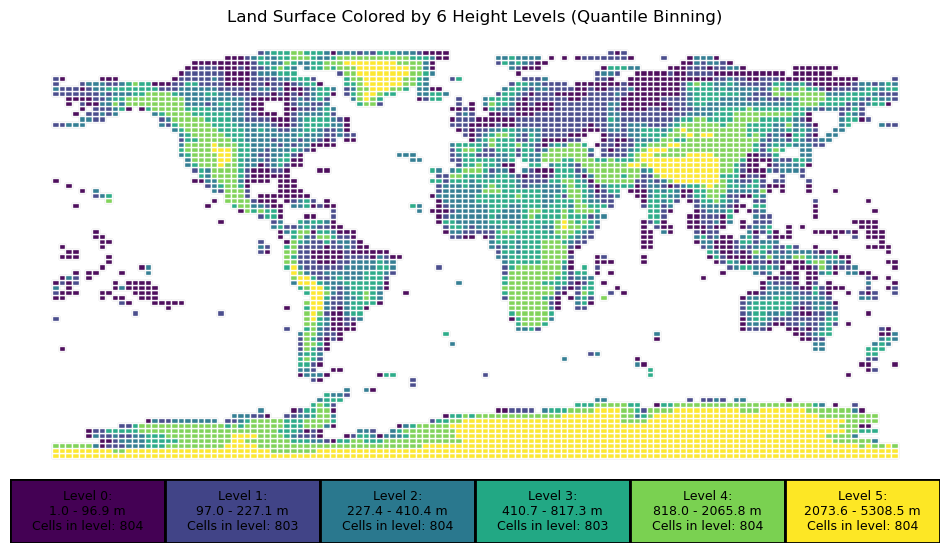

In [28]:
# Number of levels
n_levels = 6  # User-defined number of levels

# Step 1: Filter out ocean floors or very low elevations
threshold = 1  # 1 meter cutoff for land surface
gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

# Step 2: Quantile binning to redistribute elevation data evenly across levels
gdf_land['height_level'] = pd.qcut(
    gdf_land['elevation_mean'],
    q=n_levels,
    labels=range(n_levels)
)

# Convert height levels to integers for better readability
gdf_land['height_level'] = gdf_land['height_level'].astype(int)

# Define custom colors for the levels using the terrain colormap
colors = plt.cm.viridis(np.linspace(0, 1, n_levels))
cmap = mcolors.ListedColormap(colors)

# Step 3: Visualization setup using GridSpec
fig = plt.figure(figsize=(12, 10))  # Adjust overall figure size
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])  # Tighten second row

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Base grid with grey edges
gdf_land.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot the grid colored by height levels
gdf_land.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

# --- Custom Color Bar Subplot ---
ax_cbar = fig.add_subplot(gs[1])

# Reduce spacing between plots
fig.subplots_adjust(hspace=-0.5)  # Adjust spacing between GridSpec rows

# Add color swatches for each level
for i in range(n_levels):
    # Get the elevation range for the current level
    level_min = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].min()
    level_max = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].max()

    # Add a colored rectangle for each level with a black border
    ax_cbar.add_patch(
        plt.Rectangle(
            (i / n_levels, 0),  # position: (x, y) and width
            1 / n_levels,  # width of each swatch
            1,  # height of each swatch
            facecolor=colors[i],  # Fill color (facecolor)
            linewidth=2,  # Black border width
            edgecolor='black'  # Border color
        )
    )

    # Set title with level and its corresponding elevation range
    level_counts = gdf_land['height_level'].value_counts().sort_index()
    ax_cbar.text(
        (i + 0.5) / n_levels,  # X position for the text (centered)
        0.5,  # Y position for the text (vertically centered)
        f"Level {i}:\n{level_min:.1f} - {level_max:.1f} m\nCells in level: {level_counts[i]}", # textcontent
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')  # Hide the axis

plt.savefig(f'figures/elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}.jpg', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}.png', bbox_inches='tight')

plt.show()

### 7 levels

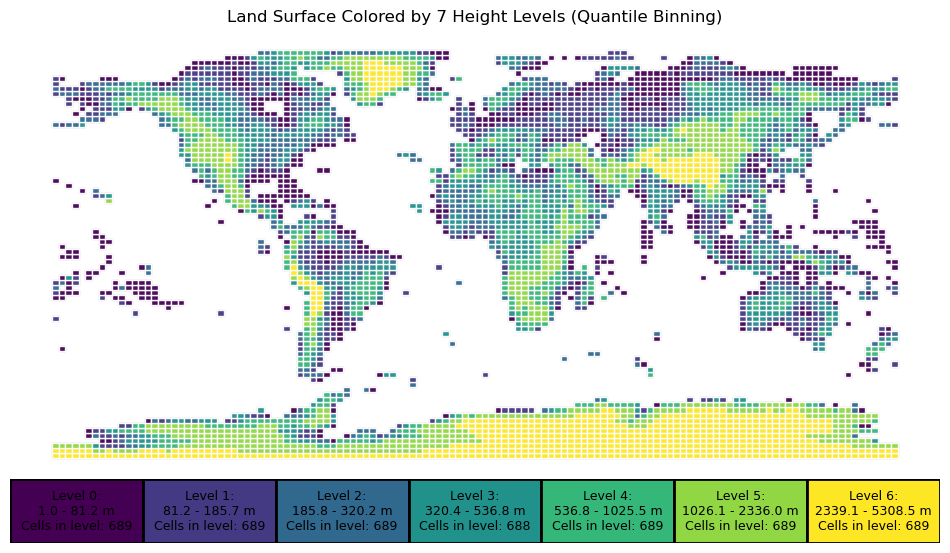

In [29]:
# Number of levels
n_levels = 7  # User-defined number of levels

# Step 1: Filter out ocean floors or very low elevations
threshold = 1  # 1 meter cutoff for land surface
gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

# Step 2: Quantile binning to redistribute elevation data evenly across levels
gdf_land['height_level'] = pd.qcut(
    gdf_land['elevation_mean'],
    q=n_levels,
    labels=range(n_levels)
)

# Convert height levels to integers for better readability
gdf_land['height_level'] = gdf_land['height_level'].astype(int)

# Define custom colors for the levels using the terrain colormap
colors = plt.cm.viridis(np.linspace(0, 1, n_levels))
cmap = mcolors.ListedColormap(colors)

# Step 3: Visualization setup using GridSpec
fig = plt.figure(figsize=(12, 10))  # Adjust overall figure size
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])  # Tighten second row

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Base grid with grey edges
gdf_land.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot the grid colored by height levels
gdf_land.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

# --- Custom Color Bar Subplot ---
ax_cbar = fig.add_subplot(gs[1])

# Reduce spacing between plots
fig.subplots_adjust(hspace=-0.5)  # Adjust spacing between GridSpec rows

# Add color swatches for each level
for i in range(n_levels):
    # Get the elevation range for the current level
    level_min = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].min()
    level_max = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].max()

    # Add a colored rectangle for each level with a black border
    ax_cbar.add_patch(
        plt.Rectangle(
            (i / n_levels, 0),  # position: (x, y) and width
            1 / n_levels,  # width of each swatch
            1,  # height of each swatch
            facecolor=colors[i],  # Fill color (facecolor)
            linewidth=2,  # Black border width
            edgecolor='black'  # Border color
        )
    )

    # Set title with level and its corresponding elevation range
    level_counts = gdf_land['height_level'].value_counts().sort_index()
    ax_cbar.text(
        (i + 0.5) / n_levels,  # X position for the text (centered)
        0.5,  # Y position for the text (vertically centered)
        f"Level {i}:\n{level_min:.1f} - {level_max:.1f} m\nCells in level: {level_counts[i]}",  # Text content
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')  # Hide the axis

# plt.savefig(f'figures/elevation_with_{n_levels}.pdf', bbox_inches='tight')
# plt.savefig(f'figures/elevation_with_{n_levels}.jpg', bbox_inches='tight')
# plt.savefig(f'figures/elevation_with_{n_levels}.png', bbox_inches='tight')

plt.show()

## Add surface color

We will attempt to downsample the colors of the bare earth surface to add to our lego map.

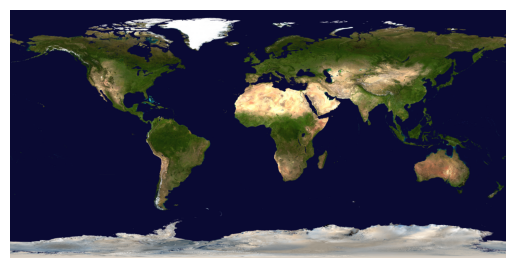

In [10]:
# https://svs.gsfc.nasa.gov/vis/a000000/a002900/a002915/bluemarble-2048.png
# thankfully this is in the same projection as our other assets
img = mpimg.imread('figures/bluemarble-2048.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

First, let's count the number of colors that the above image has.

In [36]:
# load the image and convert to RGB mode
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# convert image to a numpy array
image_array = np.array(image)

# reshape the array into a list of RGB values
pixels = image_array.reshape(-1, 3)

# count unique colors
unique_colors = np.unique(pixels, axis=0)
print(f"Number of unique colors: {len(unique_colors)}")

Number of unique colors: 220909


That's quite a large number of colors. We'll use the Median Cut algorithm to cluster the colors into a much smaller number. Let's see what a much reduced amount (≤15) gives us.

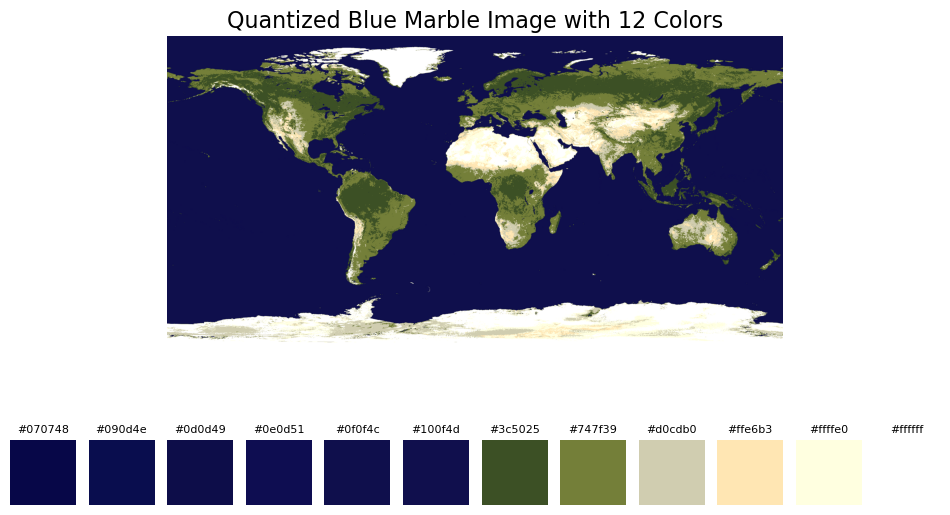

In [37]:
n_colors = 12
brightness_factor = 1.5  # factor to increase brightness

# load the image and convert to RGB
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# enhance the brightness
enhancer = ImageEnhance.Brightness(image)
brightened_image = enhancer.enhance(brightness_factor)

# apply quantization with Median Cut
quantized_image = brightened_image.quantize(method=Image.MEDIANCUT, colors=n_colors).convert('RGB')

# save the quantized image
saved_img_path = f'figures/bluemarble-2048_downsampled_with_{n_colors}_colors.png'
quantized_image.save(saved_img_path)

# get the unique colors from the quantized image
unique_colors = np.unique(np.array(quantized_image).reshape(-1, 3), axis=0)

# convert RGB to HEX
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# create the figure and grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.5)

# main plot: quantized image
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(quantized_image)
ax_main.axis('off')
ax_main.set_title(f'Quantized Blue Marble Image with {n_colors} Colors', fontsize=16)

# subplots: color swatches
gs_swatch = GridSpecFromSubplotSpec(1, n_colors, subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color) in enumerate(zip(unique_colors, hex_colors)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_title(hex_color, fontsize=8, pad=5)

# save the plot
plt.savefig(f'figures/bluemarble-2048_downsampled_{n_colors}_example.png')

plt.show()

### Discretize surface color

In [38]:
saved_img_path = f'figures/bluemarble-2048_downsampled_with_12_colors.png'

In [39]:
height = 80
width = 128

In [48]:
import numpy as np
from scipy import ndimage

def block_mean_rgb(img_array, factor):
    """
    Downsample an RGB image array using block mean.

    Parameters:
        img_array (numpy.ndarray): Input array of shape (H, W, C) (RGB format).
        factor (int): Downsampling factor for both height and width.

    Returns:
        numpy.ndarray: Downsampled image array of shape (H//factor, W//factor, C).
    """
    assert img_array.ndim == 3, "Input must be a 3D array (H, W, C)"
    assert isinstance(factor, int), "Factor must be an integer"
    
    # Separate the channels
    channels = [img_array[:, :, i] for i in range(img_array.shape[2])]
    
    # Apply block mean to each channel
    downsampled_channels = []
    for channel in channels:
        sx, sy = channel.shape
        X, Y = np.ogrid[0:sx, 0:sy]
        regions = sy // factor * (X // factor) + Y // factor
        res = ndimage.mean(
            channel,
            labels=regions,
            index=np.arange(regions.max() + 1)
        )
        res.shape = (sx // factor, sy // factor)
        downsampled_channels.append(res)
    
    # Stack the downsampled channels back together
    return np.stack(downsampled_channels, axis=-1)

def resize_to_dimensions(img_array, target_height, target_width):
    """
    Downsample an RGB image array to target dimensions using block mean.

    Parameters:
        img_array (numpy.ndarray): Input array of shape (H, W, C) (RGB format).
        target_height (int): Desired height of the output image.
        target_width (int): Desired width of the output image.

    Returns:
        numpy.ndarray: Resized image array of shape (target_height, target_width, C).
    """
    assert img_array.ndim == 3, "Input must be a 3D array (H, W, C)"
    
    original_height, original_width, num_channels = img_array.shape
    factor_y = original_height // target_height
    factor_x = original_width // target_width
    
    # Validate that the factors are valid
    if original_height % target_height != 0 or original_width % target_width != 0:
        raise ValueError("Target dimensions must evenly divide the original dimensions.")
    
    # Separate the channels
    channels = [img_array[:, :, i] for i in range(num_channels)]
    
    # Apply block mean to each channel
    resized_channels = []
    for channel in channels:
        sx, sy = channel.shape
        X, Y = np.ogrid[0:sx, 0:sy]
        regions = (sy // factor_x) * (X // factor_y) + (Y // factor_x)
        res = ndimage.mean(
            channel,
            labels=regions,
            index=np.arange(regions.max() + 1)
        )
        res.shape = (sx // factor_y, sy // factor_x)
        resized_channels.append(res)
    
    # Stack the resized channels back together
    return np.stack(resized_channels, axis=-1)

In [47]:
saved_image_path = 'figures/bluemarble-2048_downsampled_with_12_colors.png'
img = Image.open(saved_image_path).convert('RGB')
img_array = np.array(img)

# Resize the image to 80x128 pixels
target_height = 80
target_width = 128
resized_img = resize_to_dimensions(img_array, target_height, target_width)

print("Original shape:", img_array.shape)
print("Resized shape:", resized_img.shape)

ValueError: Target dimensions must evenly divide the original dimensions.

loaded image
downsample image
update image dimensions
precompute bounds for all grid cells
vectorize and clip bounds to pixel coordinates
process all grid cells in parallel
assign colors back to grid
discretize colors into levels


KeyboardInterrupt: 

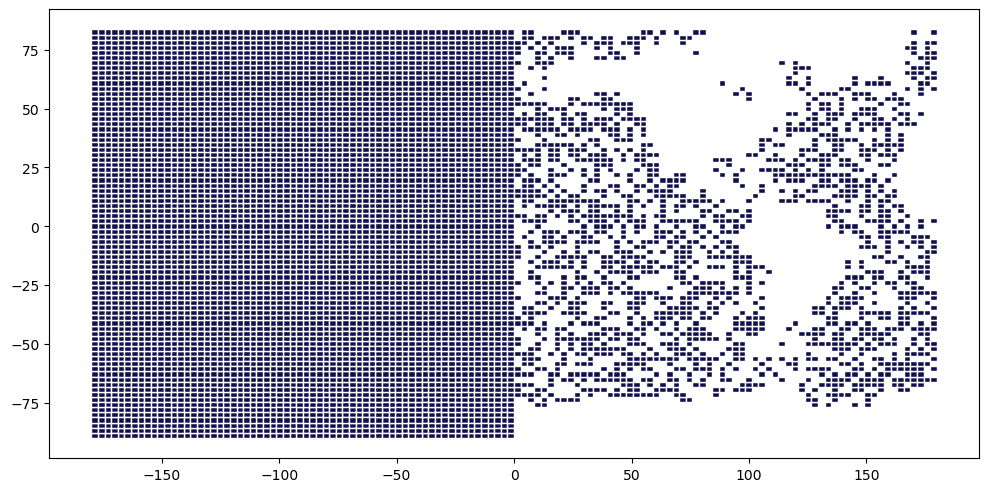

In [42]:
from PIL import Image
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Load the PNG image
img = Image.open(saved_img_path).convert("RGB")  # convert to RGB
img_array = np.array(img)
print('loaded image')

# Downsample the image (optional, for performance on large images)
img_height, img_width, _ = img_array.shape
resize_factor = 4  # adjust the factor as needed
img_resized = img.resize((img_width // resize_factor, img_height // resize_factor))
img_array_resized = np.array(img_resized)
print('downsample image')

# Update image dimensions
img_height, img_width, _ = img_array_resized.shape
print('update image dimensions')

# Precompute bounds for all grid cells
# Ensure geometry bounds are correctly extracted and unpacked
bounds = gdf_grid.geometry.bounds  # This returns a DataFrame
gdf_grid["minx"] = bounds["minx"]
gdf_grid["miny"] = bounds["miny"]
gdf_grid["maxx"] = bounds["maxx"]
gdf_grid["maxy"] = bounds["maxy"]
print('precompute bounds for all grid cells')

# Vectorize and clip bounds to pixel coordinates
px_min = np.clip((gdf_grid["minx"] / 360 * img_width).astype(int), 0, img_width - 1)
py_min = np.clip(((90 - gdf_grid["maxy"]) / 180 * img_height).astype(int), 0, img_height - 1)
px_max = np.clip((gdf_grid["maxx"] / 360 * img_width).astype(int), 0, img_width - 1)
py_max = np.clip(((90 - gdf_grid["miny"]) / 180 * img_height).astype(int), 0, img_height - 1)
print('vectorize and clip bounds to pixel coordinates')

# Function to process a single polygon and calculate average color
def process_polygon(px_min, py_min, px_max, py_max, img):
    roi = img[py_min:py_max, px_min:px_max, :]
    if roi.size > 0:
        avg_color = np.mean(roi, axis=(0, 1)).astype(int)  # calculate mean without reshape
    else:
        avg_color = [16, 15, 77]  # default to ocean blue
    return tuple(avg_color)

# Process all grid cells in parallel
bounds_list = list(zip(px_min, py_min, px_max, py_max))
cell_colors = Parallel(n_jobs=-1)(
    delayed(process_polygon)(px_min, py_min, px_max, py_max, img_array_resized)
    for px_min, py_min, px_max, py_max in bounds_list
)
print('process all grid cells in parallel')

# Assign colors back to the grid
gdf_grid["color"] = cell_colors
print('assign colors back to grid')

# Discretize colors into levels
n_levels = 6
gdf_grid["color_level"] = pd.qcut(
    [sum(color) + np.random.uniform(-0.01, 0.01) for color in gdf_grid["color"]],  # add slight noise
    q=n_levels,
    labels=range(n_levels)
)
print('discretize colors into levels')

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
for color, level in zip(gdf_grid["color"], gdf_grid["color_level"]):
    r, g, b = color
    plt_color = (r / 255, g / 255, b / 255)  # normalize RGB values
    gdf_grid[gdf_grid["color_level"] == level].plot(
        ax=ax, color=plt_color, edgecolor="white"
    )


ax.axis("off")
plt.title("Grid with Discretized Surface Colors")
plt.show()

In [52]:
# load the PNG image
img = Image.open(saved_img_path).convert("RGB")  # convert to RGB
img_array = np.array(img)

# match the image size to the grid
img_height, img_width, _ = img_array.shape

# calculate average color for each grid cell
def calculate_cell_colors(grid, img, img_width, img_height, num_cells_x, num_cells_y):
    cell_colors = []
    for poly in grid.geometry:
        # map grid coordinates to image pixel coordinates
        minx, miny, maxx, maxy = poly.bounds
        px_min = int(minx / 360 * img_width)  # assuming world coordinates
        py_min = int((90 - maxy) / 180 * img_height)
        px_max = int(maxx / 360 * img_width)
        py_max = int((90 - miny) / 180 * img_height)
        
        # ensure indices are within bounds
        px_min = np.clip(px_min, 0, img_width - 1)
        py_min = np.clip(py_min, 0, img_height - 1)
        px_max = np.clip(px_max, 0, img_width - 1)
        py_max = np.clip(py_max, 0, img_height - 1)

        # extract the region of interest
        roi = img[py_min:py_max, px_min:px_max, :]
        if roi.size > 0:
            avg_color = np.mean(roi.reshape(-1, 3), axis=0)  # average color
            avg_color = avg_color.astype(int)
        else:
            avg_color = [16, 15, 77]  # default to ocean blue if no data
        cell_colors.append(tuple(avg_color))
    return cell_colors

In [ ]:
# load the PNG image
img = Image.open(saved_img_path).convert("RGB")  # convert to RGB
img_array = np.array(img)

# match the image size to the grid
img_height, img_width, _ = img_array.shape

# calculate average color for each grid cell
def calculate_cell_colors(grid, img, img_width, img_height, num_cells_x, num_cells_y):
    cell_colors = []
    for poly in grid.geometry:
        # map grid coordinates to image pixel coordinates
        minx, miny, maxx, maxy = poly.bounds
        px_min = int(minx / 360 * img_width)  # assuming world coordinates
        py_min = int((90 - maxy) / 180 * img_height)
        px_max = int(maxx / 360 * img_width)
        py_max = int((90 - miny) / 180 * img_height)
        
        # ensure indices are within bounds
        px_min = np.clip(px_min, 0, img_width - 1)
        py_min = np.clip(py_min, 0, img_height - 1)
        px_max = np.clip(px_max, 0, img_width - 1)
        py_max = np.clip(py_max, 0, img_height - 1)

        # extract the region of interest
        roi = img[py_min:py_max, px_min:px_max, :]
        if roi.size > 0:
            avg_color = np.mean(roi.reshape(-1, 3), axis=0)  # average color
            avg_color = avg_color.astype(int)
        else:
            avg_color = [16, 15, 77]  # default to ocean blue if no data
        cell_colors.append(tuple(avg_color))
    return cell_colors

# calculate colors for each grid cell
gdf_grid["color"] = calculate_cell_colors(gdf_grid, img_array, img_width, img_height, width, height)

# assign bins or levels
n_levels = 6
gdf_grid["color_level"] = pd.qcut( # add noise to ensure no duplicates
    [sum(color) + np.random.uniform(-0.01, 0.01) for color in gdf_grid["color"]],  # sum of RGB values as a proxy
    q=n_levels,
    labels=range(n_levels)
)

# visualization
fig, ax = plt.subplots(figsize=(12, 8))
for color, level in zip(gdf_grid["color"], gdf_grid["color_level"]):
    r, g, b = color
    plt_color = (r / 255, g / 255, b / 255)
    gdf_grid[gdf_grid["color_level"] == level].plot(
        ax=ax, color=plt_color, edgecolor="white"
    )

ax.axis("off")
plt.title("Grid with Discretized Surface Colors")
plt.show()

In [ ]:
# Step 1: Load the PNG image
img = Image.open(saved_img_path)  # Replace with the path to your PNG
img_array = np.array(img)  # Convert to numpy array for processing

# Step 2: Quantize the image colors
n_colors = 6  # Number of discrete color levels
quantized_img = img.quantize(colors=n_colors)  # Use Pillow's quantize

# Convert back to numpy array for analysis
quantized_array = np.array(quantized_img)

# Step 3: Visualize the quantized image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img_array)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Quantized image
ax[1].imshow(quantized_array, cmap='tab10')  # Optional: custom colormap
ax[1].set_title(f"Quantized Image with {n_colors} Colors")
ax[1].axis("off")

plt.tight_layout()
plt.show()